# Fashion MNIST CNN Model Average accuracy of 86%

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Converting Binary File to CSV

In [2]:
def convert_bin_to_csv(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    # Removing headers
    f.read(16)
    l.read(8)
    
    # array to store labels with image matrix
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        # writing into the CSV files
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [3]:
# converting binary file to CSV files
convert_bin_to_csv("./data/train-images-idx3-ubyte", "./data/train-labels-idx1-ubyte",
        "./data/fashion_mnist_train.csv", 60000)
convert_bin_to_csv("./data/t10k-images-idx3-ubyte", "./data/t10k-labels-idx1-ubyte",
        "./data/fashion_mnist_test.csv", 10000)

## 2. Fashion MNIST Class

In [4]:
class FashionMNIST(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file);
        # Turning the image matrix to the one commonly foun in PyTorch
        self.images = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)
        self.labels = np.array(data.iloc[:, 0]);
        self.transform = transform;

    def __len__(self):
        # Setting the standard length function
        return len(self.labels)

    def __getitem__(self, idx):
        # Setting get function to use dataset as tuple
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return (torch.Tensor(image),torch.from_numpy(np.array(label)))

## 3. Load Dataset

In [5]:
train_dataset = FashionMNIST(csv_file='data/fashion_mnist_train.csv')
test_dataset = FashionMNIST(csv_file='data/fashion_mnist_test.csv')

In [6]:
type(train_dataset[0])

tuple

In [7]:
train_dataset[0]

(tensor([[[   0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
              0.,    0.,   41.,  188.,  103.,   54.,   48.,   43.,
             87.,  168.,  133.,   16.,    0.,    0.,    0.,    0.,
              0.,    0.,    0.,    0.],
          [   0.,    0.,    0.,    1.,    0.,    0.,    0.,   49.,
            136.,  219.,  216.,  228.,  236.,  255.,  255.,  255.,
            255.,  217.,  215.,  254.,  231.,  160.,   45.,    0.,
              0.,    0.,    0.,    0.],
          [   0.,    0.,    0.,    0.,    0.,   14.,  176.,  222.,
            224.,  212.,  203.,  198.,  196.,  200.,  215.,  204.,
            202.,  201.,  201.,  201.,  209.,  218.,  224.,  164.,
              0.,    0.,    0.,    0.],
          [   0.,    0.,    0.,    0.,    0.,  188.,  219.,  200.,
            198.,  202.,  198.,  199.,  199.,  201.,  196.,  198.,
            198.,  200.,  200.,  200.,  200.,  201.,  200.,  225.,
             41.,    0.,    0.,    0.],
          [   0.,    0.,    0.,    0

In [8]:
plt.clf()
show_img = train_dataset[0][0].numpy().reshape(28, 28)

<Figure size 432x288 with 0 Axes>

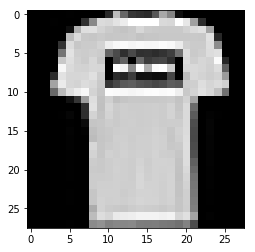

In [9]:
plt.imshow(show_img, cmap='gray')

## 4. Make Dataset Iterable

In [34]:
batch_size = 50
# 6000 iterations
# More iterations don't lead to any significant change
# Lesser iterations cause a drop of 3-4%
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset)/batch_size))

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         shuffle = False)

## 5. Create Model Class

### Brief on model class

1. No input needs to be passed while initializing all the sizes have been precomputed and used. 
2. Same padding is used for better results
3. 2 Convolution layers have been used (3rd layer doesn't provide much benefit)
4. ReLu has been used as it provides best result in CNN

In [35]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        
        #Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=5, stride = 1, padding =2)
        self.relu1 = nn.ReLU()
        
        # Maxpool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=5, stride = 1, padding =2)
        self.relu2 = nn.ReLU()
        
        # Maxpool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Final out
        self.fcl1 = nn.Linear(32*7*7, 10)
        
    def forward(self, x):
        #Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        #Maxpool 1
        out = self.maxpool1(out)
        
        #Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)
        
        #Maxpool 2
        out = self.maxpool2(out)
        
        #Final Out
        out = out.view(out.size(0),-1)
        out = self.fcl1(out)
        
        return out

## 6. Instantiate Model Class

In [36]:
model = CNNModel()

## 7. Instantiate Loss Class

In [37]:
criterion = nn.CrossEntropyLoss()

## 8. Instantiate Optimizer Class

After my trial I got the best result with a learning rate of 0.015

In [40]:
learning_rate = 0.015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 9. Train Model

### Brief about the training 

1. SGD is used as optimizer as it's Fast
2. After every 500 iterations average accuracy is printed
3. Cross Entropy Loss is used to calculate the loss

In [41]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #load images as Variable
        images = Variable(images)
        labels = Variable(labels)
        
        #clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        #Forward pass to get output/logits
        outputs = model(images)
        
        #calculate loss: softmax ---> cross entropy loss
        loss = criterion(outputs, labels)
        
        #getting gradients w.r.t parameters
        loss.backward()
        
        #updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter%500 == 0:
            #Calculate accuracy
            correct = 0
            total = 0
            #iterate through the test dataset
            for images,labels in test_loader:
                images = Variable(images)                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            
            print('Iteration {}, loss {}, accuracy {}'.format(iter, loss.data[0], accuracy))

/home/aishwarya/env/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration 500, loss 0.26551762223243713, accuracy 84
Iteration 1000, loss 0.34515175223350525, accuracy 85
Iteration 1500, loss 0.5504879951477051, accuracy 84
Iteration 2000, loss 0.39085257053375244, accuracy 85
Iteration 2500, loss 0.32056155800819397, accuracy 86
Iteration 3000, loss 0.3982406258583069, accuracy 85
Iteration 3500, loss 0.3833635449409485, accuracy 85
Iteration 4000, loss 0.34555724263191223, accuracy 85
Iteration 4500, loss 0.2547236382961273, accuracy 84
Iteration 5000, loss 0.10910201072692871, accuracy 86
Iteration 5500, loss 0.4550250768661499, accuracy 86
Iteration 6000, loss 0.29969465732574463, accuracy 86
